In [153]:
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

%matplotlib inline

In [40]:
start = datetime.datetime(1998,1,1)
end = datetime.datetime.now()

In [41]:
ff_df = pd.read_csv('data/fedfunds2.csv')
ff_df = ff_df[::-1]
ff_df['Date'] = pd.to_datetime(ff_df['Date'])
ff_df.set_index('Date')

,Rate
Date,
2020-01-29,1.55
2020-01-28,1.55
2020-01-27,1.55
2020-01-24,1.55
2020-01-23,1.55
...,...
1998-01-07,5.29
1998-01-06,5.35
1998-01-05,5.51


In [42]:
libor_df = pd.read_csv('data/libor1.csv')
libor_df = libor_df[::-1]
libor_df['Date'] = pd.to_datetime(libor_df['Date'])
libor_df.set_index('Date')

,Rate
Date,
2020-01-24,1.6595
2020-01-23,1.66088
2020-01-22,1.65938
2020-01-21,1.6595
2020-01-20,1.65338
...,...
1998-01-08,5.62891
1998-01-07,5.62891
1998-01-06,5.66797


In [43]:
mortgage_df = pd.read_csv('data/mortgage2.csv')
mortgage_df = mortgage_df[::-1]
mortgage_df['Date'] = pd.to_datetime(mortgage_df['Date'])
mortgage_df.set_index('Date')

,Rate
Date,
2020-01-01,3.51
2019-12-01,3.74
2019-11-01,3.68
2019-10-01,3.78
2019-09-01,3.64
...,...
1998-05-01,7.07
1998-04-01,7.15
1998-03-01,7.08


In [44]:
vacancy_df = pd.read_csv('data/vacancies2.csv')
vacancy_df = vacancy_df[::-1]
vacancy_df['Date'] = pd.to_datetime(vacancy_df['Date'])
vacancy_df.set_index('Date')

,Rate
Date,
2020-02-01,6.4
2020-01-01,6.4
2019-12-01,6.4
2019-11-01,6.4
2019-10-01,6.4
...,...
1999-01-01,8.2
1998-10-01,7.8
1998-07-01,8.2


In [45]:
AMT = pdr.get_data_yahoo('AMT', start, end)
AMT = AMT.resample('MS').mean()
AMT['Name'] = pd.Series()
AMT['Name'] = 'AMT'

CUBE = pdr.get_data_yahoo('CUBE', start, end)
CUBE = CUBE.resample('MS').mean()
CUBE['Name'] = pd.Series()
CUBE['Name'] = 'CUBE'

DEI = pdr.get_data_yahoo('DEI')
DEI = DEI.resample('MS').mean()
DEI['Name'] = pd.Series()
DEI['Name'] = 'DEI'

PLD = pdr.get_data_yahoo('PLD')
PLD = PLD.resample('MS').mean()
PLD['Name'] = pd.Series()
PLD['Name'] = 'PLD'

FR = pdr.get_data_yahoo('FR')
FR = FR.resample('MS').mean()
FR['Name'] = pd.Series()
FR['Name'] = 'FR'

MAA = pdr.get_data_yahoo('MAA')
MAA = MAA.resample('MS').mean()
MAA['Name'] = pd.Series()
MAA['Name'] = 'MAA'

MGP = pdr.get_data_yahoo('MGP')
MGP = MGP.resample('MS').mean().ffill()
MGP['Name'] = pd.Series()
MGP['Name'] = 'MGP'

MPW = pdr.get_data_yahoo('MPW')
MPW = MPW.resample('MS').mean()
MPW['Name'] = pd.Series()
MPW['Name'] = 'MPW'

WY = pdr.get_data_yahoo('WY')
WY = WY.resample('MS').mean()
WY['Name'] = pd.Series()
WY['Name'] = 'WY'

In [46]:
reit_df_list = [AMT, CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY]
for reit in reit_df_list:
    reit.index = pd.to_datetime(reit.index)

In [47]:
all_reits_df = AMT.append([CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY])
all_reits_df.to_csv('data/all_reits_dataframe.csv')

In [49]:
all_reits_df.drop(labels = ['High', 'Low', 'Open', 'Close', 'Volume'], axis = 1, inplace = True)

In [126]:
all_reits_df = all_reits_df[::-1]

In [127]:
reit_df_name_list = ['AMT', 'CUBE', 'DEI', 'PLD', 'FR', 'MAA', 'MGP', 'MPW', 'WY']
reit_df_dict = {}
for name in reit_df_name_list:
    df = all_reits_df.loc[all_reits_df.Name == name]
    df.drop(labels = 'Name', axis = 1,inplace = True)
    reit_df_dict[name] = df

In [128]:
def plot_reit_ts(df_dict):
    for key in df_dict.keys():
        plt.style.use('ggplot')
        df_dict[key].plot(figsize = (12,5), layout = (5, 2))
        plt.xlabel('Month')
        plt.ylabel('Adjusted Close Price')
        plt.title(f'{key} Adjusted Closing Price Over Time')
        plt.tight_layout()
        plt.show();

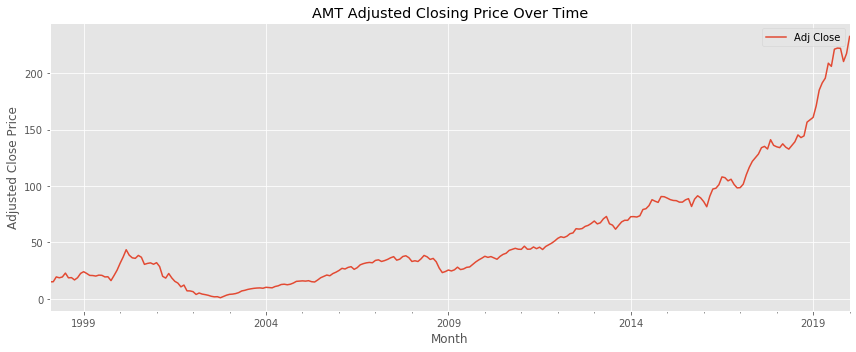

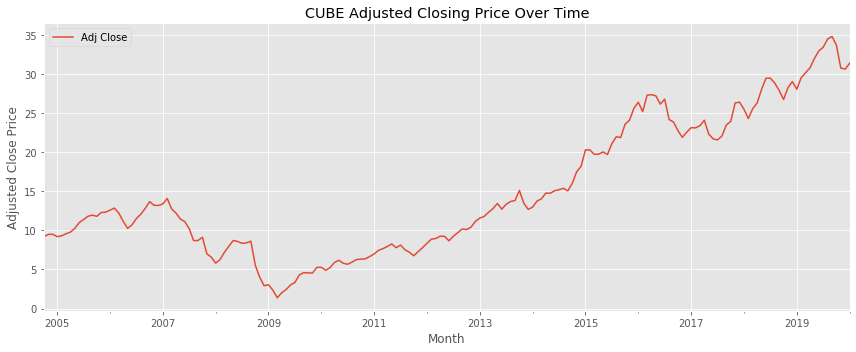

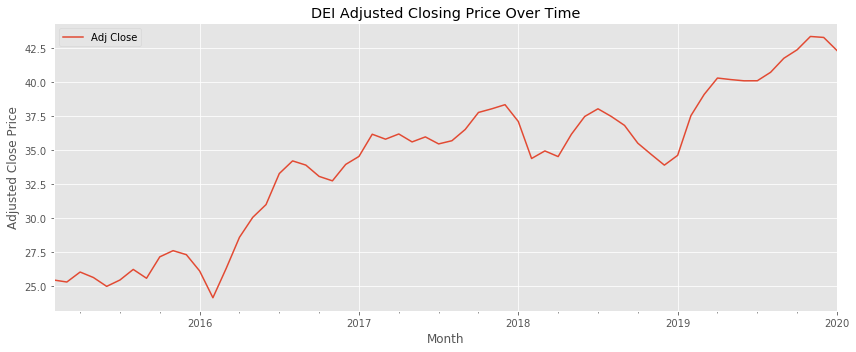

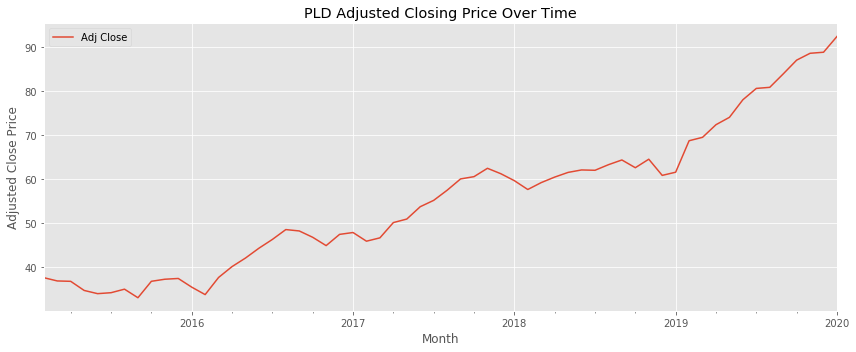

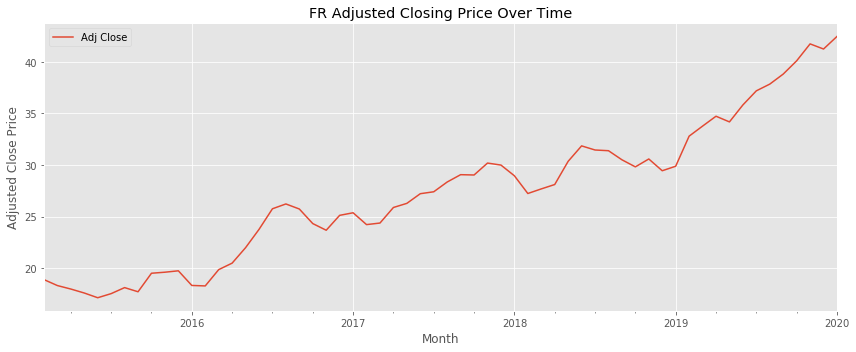

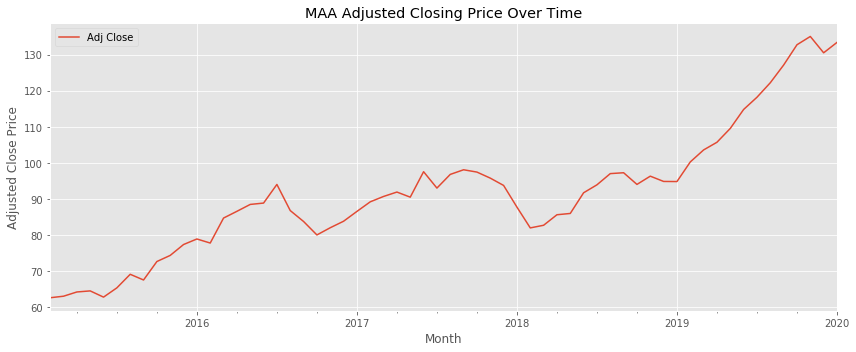

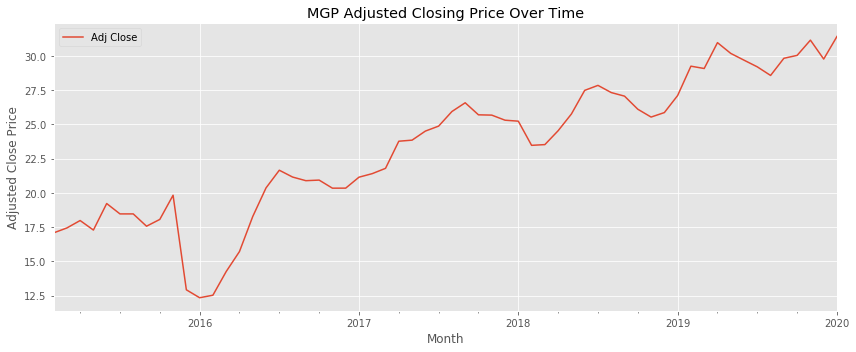

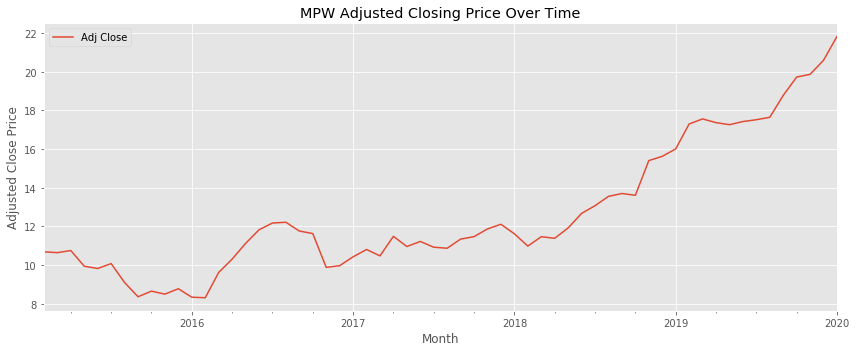

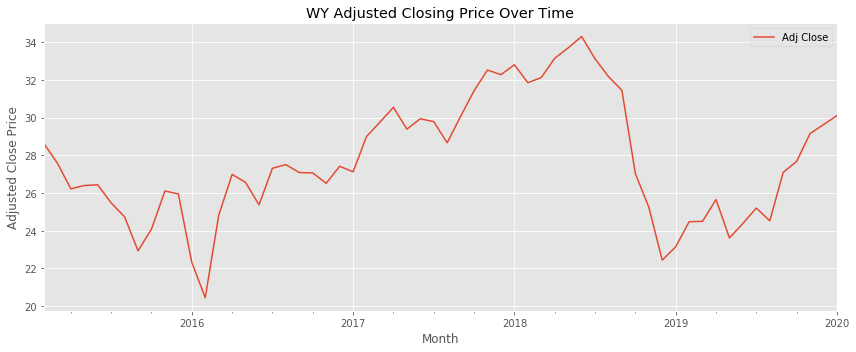

In [129]:
plot_reit_ts(reit_df_dict)

In [130]:
def decomposition(df_dict):
    for key in df_dict.keys():
        ts = df_dict[key]
        decomposition = seasonal_decompose(np.log(ts))
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
    
        # Plot with subplots
        plt.figure(figsize=(10,6))
        plt.subplot(411)
        plt.plot(np.log(ts), label='Original', color="blue")
        plt.legend(loc='best')
        plt.title(f'{key}')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color="blue")
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color="blue")
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color="blue")
        plt.legend(loc='best')
        plt.tight_layout()
        
        

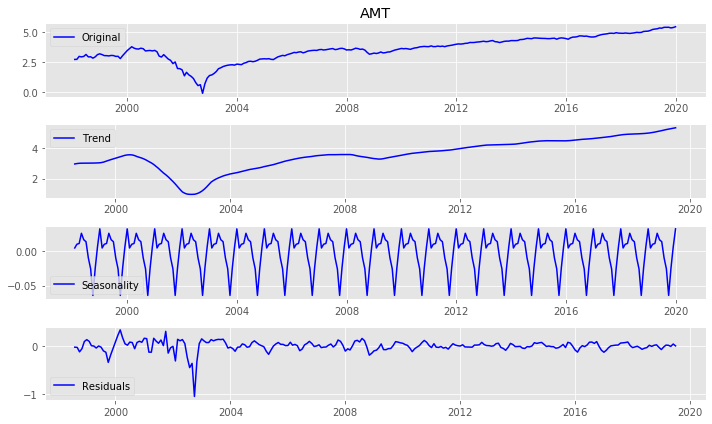

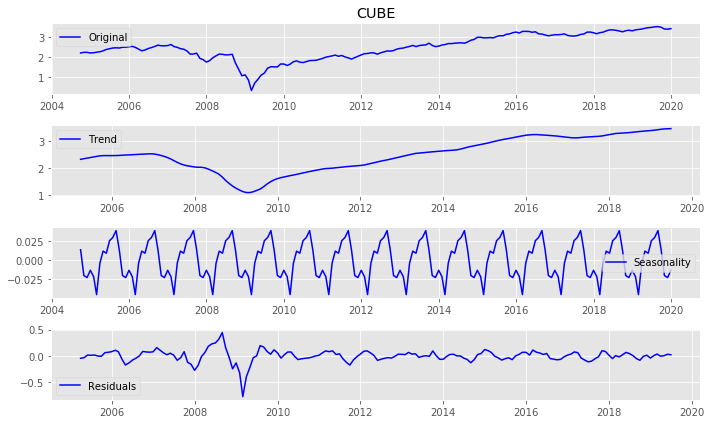

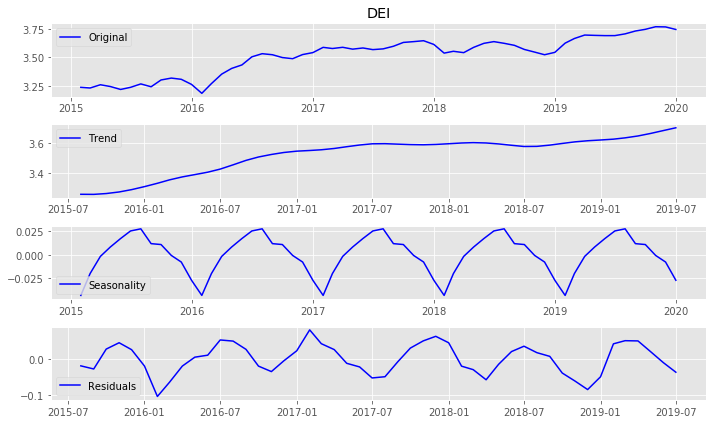

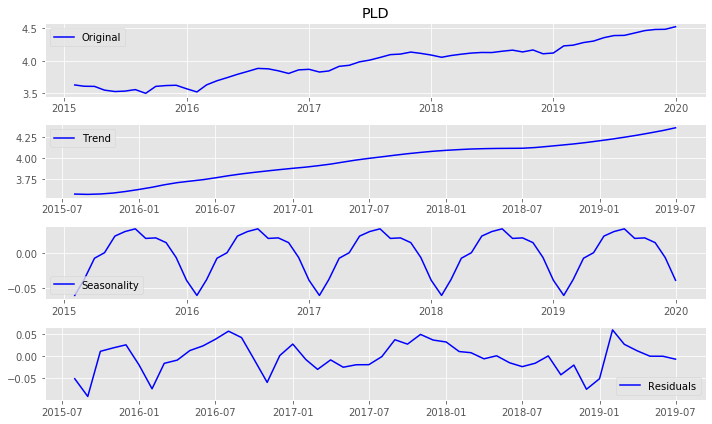

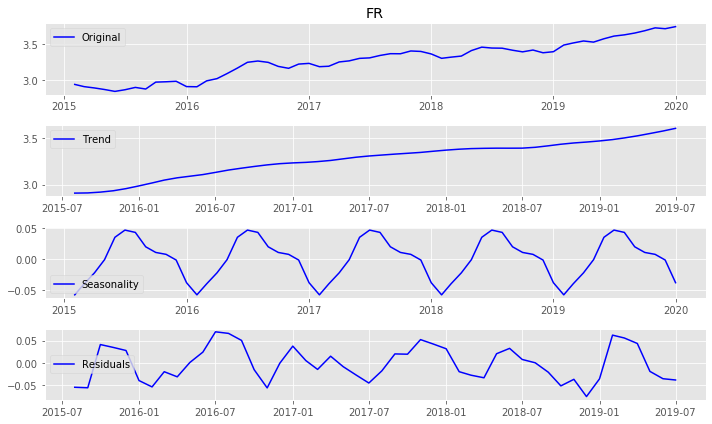

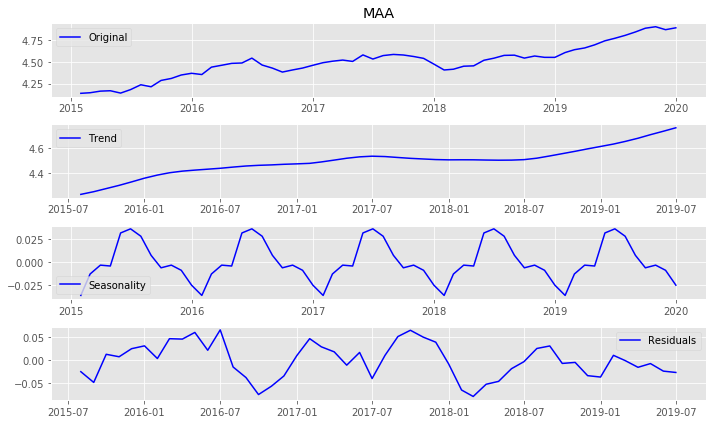

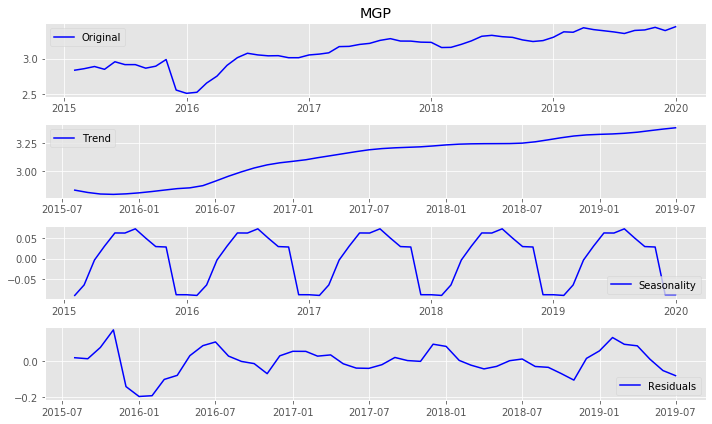

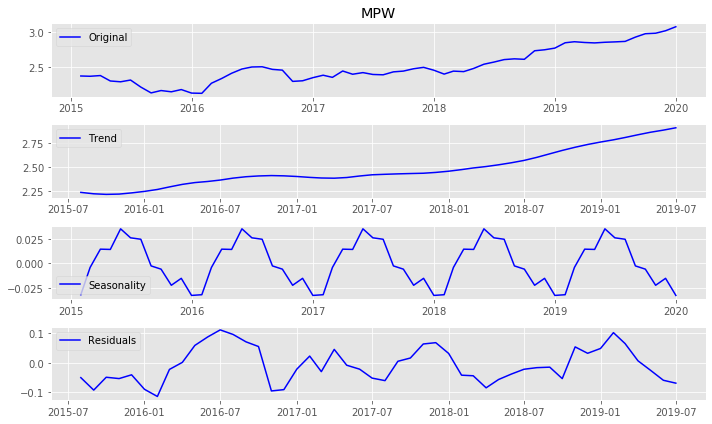

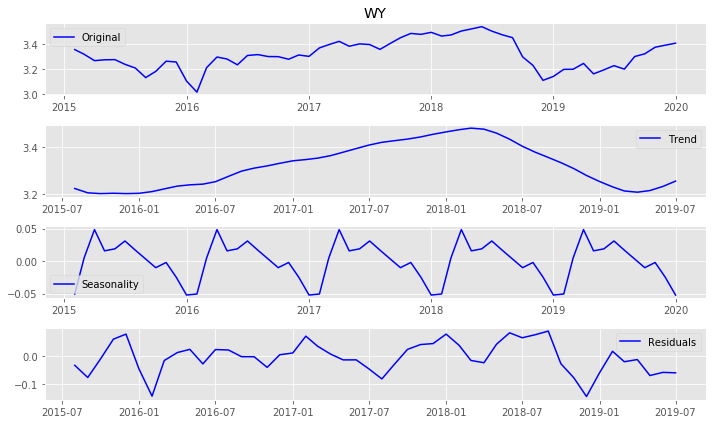

In [131]:
decomposition(reit_df_dict)

In [132]:
def differencing(df_dict):
    diff_df_dict = {}
    for key in df_dict.keys():
        diff_df_dict[key] = df_dict[key].diff(periods = 1).dropna()
        
    return diff_df_dict

In [133]:
#First order difference
diff1_reit_df_dict = differencing(reit_df_dict)

In [134]:
def dickey_fuller(df_dict):
    dftest_pvalue_dict = {}
    for key in df_dict.keys():
        dftest = adfuller(df_dict[key]['Adj Close'])
        dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
        dftest_pvalue_dict[key] = dftest[1]
        
    print(f'{((np.array(list(dftest_pvalue_dict.values())) < 0.05).sum() / len(df_dict)) * 100} % pass Dickey Fuller Test')

In [135]:
dickey_fuller(diff1_reit_df_dict)

100.0 % pass Dickey Fuller Test


In [136]:
def plot_partial_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_pacf(df_dict[key], lags = 12)
        plt.title(f'PACF - {key}')
        plt.show();

In [137]:
def plot_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_acf(df_dict[key], lags = 12)
        plt.title(f'ACF - {key}')
        plt.show();

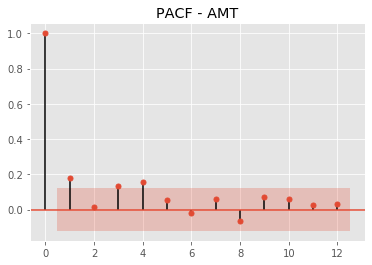

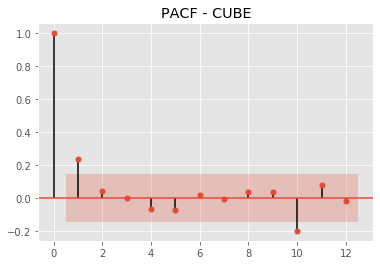

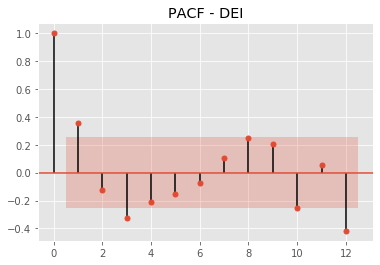

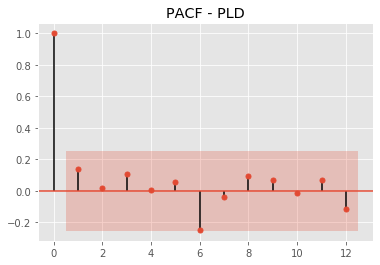

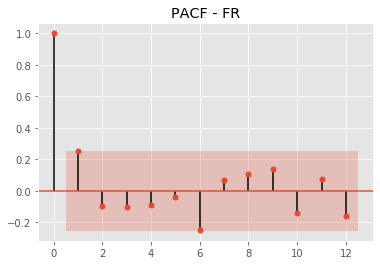

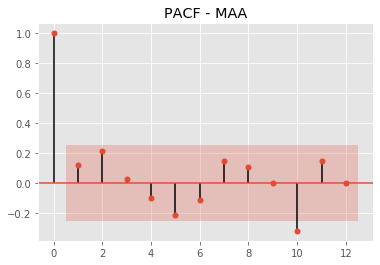

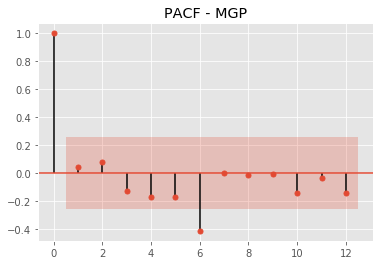

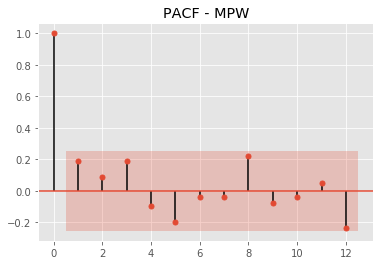

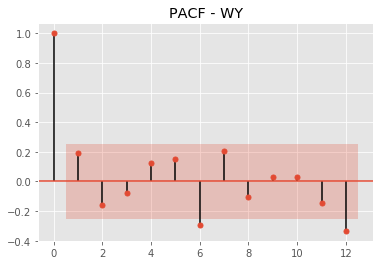

In [138]:
plot_partial_autocorrelation(diff1_reit_df_dict)

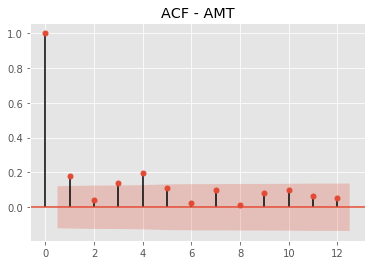

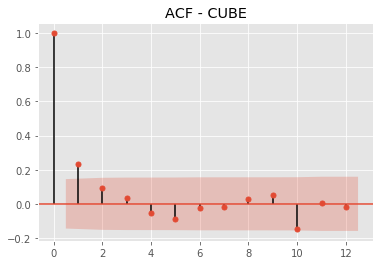

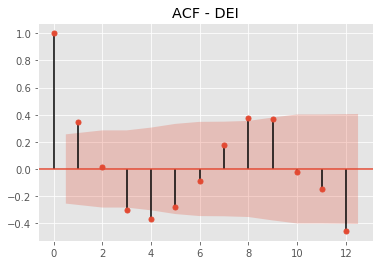

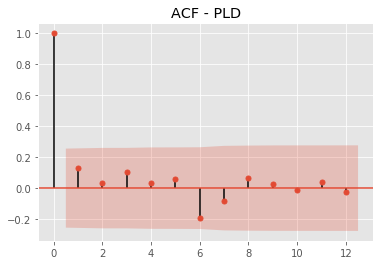

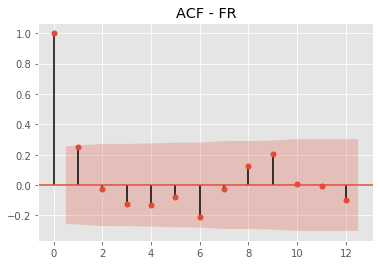

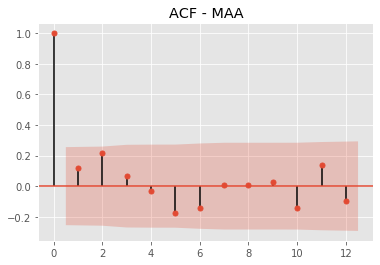

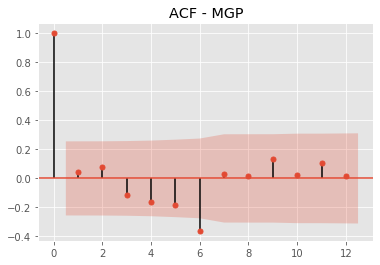

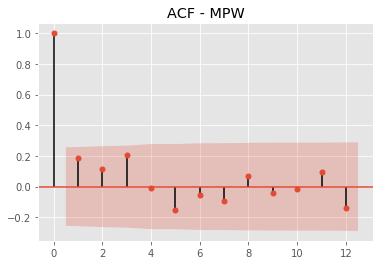

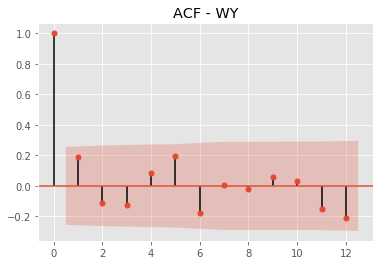

In [139]:
plot_autocorrelation(diff1_reit_df_dict)

In [140]:
best_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters1[key] = ()
    
best_parameters1['AMT'] = (3,1,3)
best_parameters1['CUBE'] = (2,1,1)
best_parameters1['DEI'] = (3,1,3)
best_parameters1['PLD'] = (0,1,0)
best_parameters1['FR'] = (1,1,0)
best_parameters1['MAA'] = (1,1,0)
best_parameters1['MGP'] = (1,1,1)
best_parameters1['MPW'] = (0,1,0)
best_parameters1['WY'] = (2,1,0)


In [141]:
best_seasonal_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters1['AMT'] = (3,1,3, 12)
    best_seasonal_parameters1['CUBE'] = (2,1,1, 12)
    best_seasonal_parameters1['DEI'] = (3,1,3, 12)
    best_seasonal_parameters1['PLD'] = (0,1,0, 12)
    best_seasonal_parameters1['FR'] = (1,1,0, 12)
    best_seasonal_parameters1['MAA'] = (1,1,0, 12)
    best_seasonal_parameters1['MGP'] = (1,1,1, 12)
    best_seasonal_parameters1['MPW'] = (0,1,0, 12)
    best_seasonal_parameters1['WY'] = (2,1,0, 12)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                          Adj Close   No. Observations:                  264
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -490.249
Date:                            Sun, 02 Feb 2020   AIC                           1006.497
Time:                                    13:28:59   BIC                           1050.071
Sample:                                01-01-2020   HQIC                          1024.111
                                     - 02-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2257      1.738      0.130      0.897      -3.180       3.631
ar.L2          0.5460  

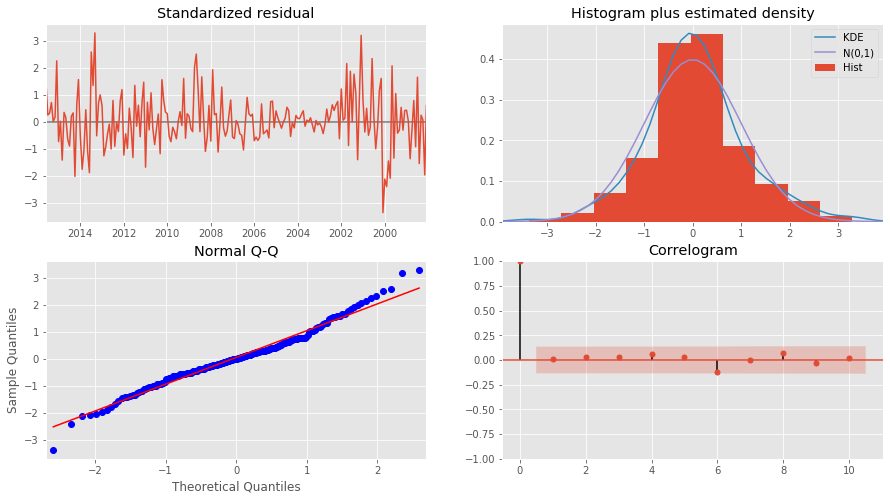

---------------------------------------------------------------
CUBE Summary                                  Statespace Model Results                                 
Dep. Variable:                          Adj Close   No. Observations:                  184
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -180.567
Date:                            Sun, 02 Feb 2020   AIC                            375.135
Time:                                    13:29:02   BIC                            395.972
Sample:                                01-01-2020   HQIC                           383.601
                                     - 10-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4042      0.563     

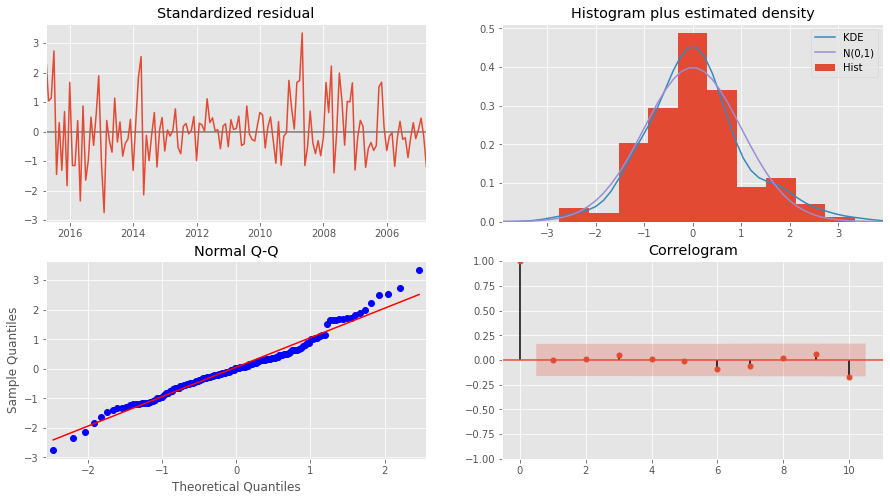

---------------------------------------------------------------


ValueError: maxlag should be < nobs

In [142]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters1[key],
                                            seasonal_order = best_seasonal_parameters1[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False)
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

In [143]:
best_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters2[key] = ()
    
best_parameters2['AMT'] = (3,1,2)
best_parameters2['CUBE'] = (1,1,1)
best_parameters2['DEI'] = (2,1,2)
best_parameters2['PLD'] = (1,1,0)
best_parameters2['FR'] = (2,1,0)
best_parameters2['MAA'] = (0,1,0)
best_parameters2['MGP'] = (0,1,1)
best_parameters2['MPW'] = (1,1,0)
best_parameters2['WY'] = (1,1,0)

In [144]:
best_seasonal_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_seasonal_parameters2[key] = ()
    
best_seasonal_parameters2['AMT'] = (3,1,2, 12)
best_seasonal_parameters2['CUBE'] = (1,1,1, 12)
best_seasonal_parameters2['DEI'] = (2,1,2, 12)
best_seasonal_parameters2['PLD'] = (1,1,0, 12)
best_seasonal_parameters2['FR'] = (2,1,0, 12)
best_seasonal_parameters2['MAA'] = (0,1,0, 12)
best_seasonal_parameters2['MGP'] = (0,1,1, 12)
best_seasonal_parameters2['MPW'] = (1,1,0, 12)
best_seasonal_parameters2['WY'] = (1,1,0, 12)

AMT Summary                                  Statespace Model Results                                 
Dep. Variable:                          Adj Close   No. Observations:                  264
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -504.502
Date:                            Sun, 02 Feb 2020   AIC                           1033.003
Time:                                    13:29:26   BIC                           1073.282
Sample:                                01-01-2020   HQIC                          1049.283
                                     - 02-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.279      0.780      -0.002       0.003
ar.L1          0.4496  

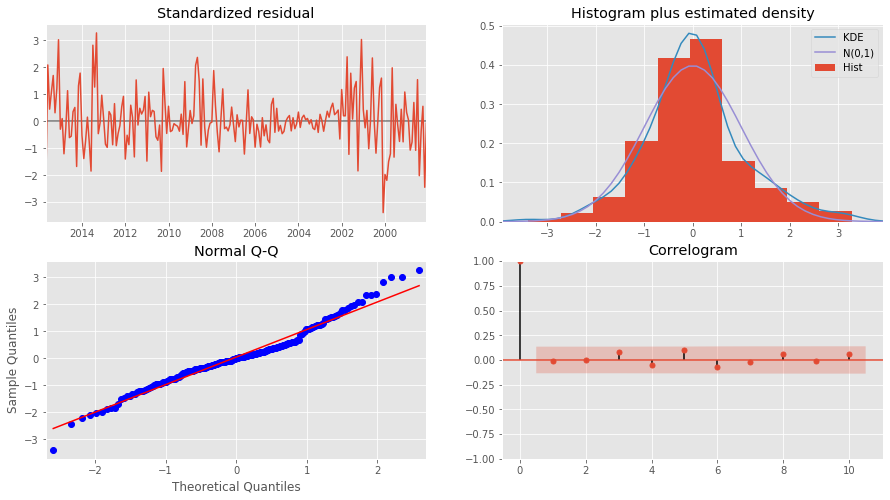

---------------------------------------------------------------
CUBE Summary                                  Statespace Model Results                                 
Dep. Variable:                          Adj Close   No. Observations:                  184
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -205.573
Date:                            Sun, 02 Feb 2020   AIC                            423.146
Time:                                    13:29:28   BIC                            441.483
Sample:                                01-01-2020   HQIC                           430.593
                                     - 10-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       8.246e-05      0.000     

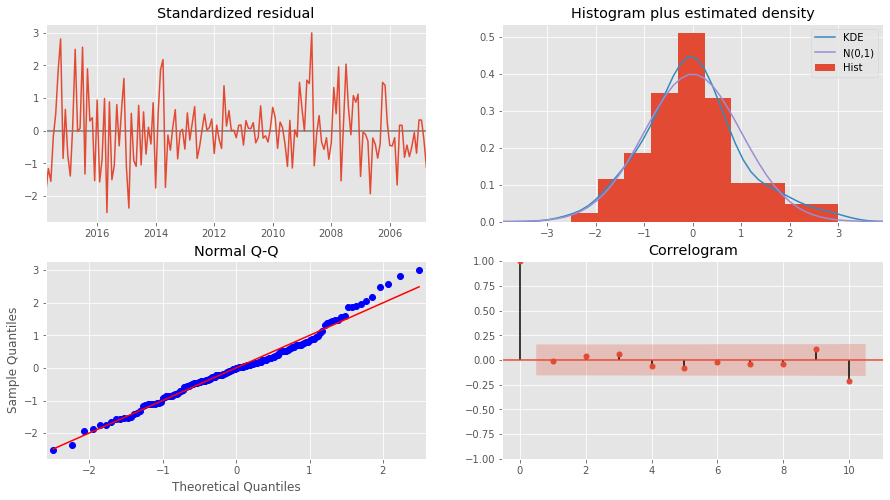

---------------------------------------------------------------


ValueError: maxlag should be < nobs

In [145]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters2[key],
                                            seasonal_order = best_seasonal_parameters2[key],
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

## Auto-ARIMA:

In [156]:
reit_df_dict['AMT']

,Adj Close
Date,
2020-01-01,232.614286
2019-12-01,217.479367
2019-11-01,210.391051
2019-10-01,222.083466
2019-09-01,222.308775
...,...
1998-06-01,19.285911
1998-05-01,18.561342
1998-04-01,19.341473


In [157]:
for key in reit_df_dict.keys():
    #split each reit dataframe into a 70% train/30% test
    train, test = model_selection.train_test_split(np.split(reit_df_dict[key], [int(.70*len(reit_df_dict[key]))]))
    
    auto_arima = pm.auto_arima(train, error_action='ignore', trace=True,
                      suppress_warnings=True,
                      seasonal=True, m=12,
                      start_p=0, start_q=0,
                      start_P=0, start_Q=0,
                      stationary=False,
                      with_intercept=False,
                      D=1,
                      trend='t)